In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torch.optim import Adam
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from plotly.colors import make_colorscale

In [2]:
class RedMulticapa(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size):
        super(RedMulticapa, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.hidden3 = nn.Linear(hidden2, hidden3)
        self.hidden4 = nn.Linear(hidden3, hidden4)
        self.hidden5 = nn.Linear(hidden4, hidden5)
        self.output = nn.Linear(hidden5, output_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.loss = nn.BCELoss()
        self.historial = []

    def feed_forward(self, X):
        x = self.hidden1(X)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.hidden3(x)
        x = self.sigmoid(x)
        x = self.hidden4(x)
        x = self.sigmoid(x)
        x = self.hidden5(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

    def back_propagate(self, X, Y):
        outputs = self.feed_forward(X)
        error = self.loss(outputs, Y)
        self.zero_grad()
        error.backward()

    def track_progress(self, error):
        self.historial.append(error.item())

    def train(self, train_X, train_Y, optimizer, ciclos=10000):
        for i in range(ciclos):
            self.back_propagate(train_X, train_Y)
            optimizer.step()
            outputs = self.feed_forward(train_X)
            error = self.loss(outputs, train_Y)
            self.track_progress(error)

    def confusion(self, test_X, test_Y):
        with torch.no_grad():
            predictions = self.feed_forward(test_X)
            for i in range(len(predictions)):
                if predictions[i] <= 0.5:
                    predictions[i] = 0
                else:
                    predictions[i] = 1

        num_classes = 2
        confusion_matrix_result = [[0, 0], [0, 0]]

        for i in range(len(test_Y)):
            true_label = test_Y[i]
            pred = predictions[i]

            if true_label == pred:
                if pred == 1:
                    confusion_matrix_result[0][0] += 1
                else:
                    confusion_matrix_result[1][1] += 1
            else:
                if true_label == 1:
                    confusion_matrix_result[1][0] += 1
                else:
                    confusion_matrix_result[0][1] += 1

        return confusion_matrix_result

In [3]:
input_size = 26
hidden1 = 70
hidden2 = 140
hidden3= 280
hidden4= 140
hidden5 = 70
output_size = 1

modelo2 = RedMulticapa(input_size, hidden1, hidden2, hidden3, hidden4, hidden5, output_size)
modelo2.load_state_dict(torch.load('modelo_entrenado_BCE_sim.pth'))
modelo2.historial = np.load('historialmodelo2_sim.npy')

In [4]:
# Leer el archivo CSV
df1 = pd.read_csv('df_control.csv')
df2 = pd.read_csv('df_control.csv')
df3 = pd.read_csv('df_control.csv')
df4 = pd.read_csv('df_control.csv')
df5 = pd.read_csv('df_control.csv')

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df = df.drop('HIVtreat', axis=1)

columnas_categoricas = df.columns
print(columnas_categoricas)


Index(['sex', 'age', 'level of education', 'ever married', 'HIV acquisition',
       'HIV-testing self-efficacy', 'Condom self-efficacy',
       'Control around sexual partners', 'Safe sex and condoms',
       'Ever had sex', 'Two or more lifetime partners',
       'Sexual debut 17 or younger', 'Two or more partners in last 12m',
       'Did not use condom at last sex', 'Sought treatment for STD symptoms',
       'Genital discharge prevalence', 'Genital warts or sores prevalence',
       'Rights within marriage', 'Reported past or current pregnancy',
       'Prevalence of any symptom of STD', 'HIV infection', 'HSV-2 infection'],
      dtype='object')


In [5]:
def aplicar_cambio(valor, original, probabilidad_cambio):
    if valor == original:
        return np.random.choice([original, (original+1)%2], p=[1 - probabilidad_cambio, probabilidad_cambio])
    return valor

In [6]:
def OneHot(df):

    encoder = OneHotEncoder()

    # 'sex' a one-hot
    sex_columna = df[['sex']]
    sex_one_hot = encoder.fit_transform(sex_columna)
    sex_one_hot_df = pd.DataFrame(sex_one_hot.toarray(), columns=encoder.get_feature_names_out(['sex']))
    df_one_hot = pd.concat([df, sex_one_hot_df], axis=1)
    df_one_hot.drop(['sex'], axis=1, inplace=True)

    # 'age' a one-hot
    age_columna = df[['age']]
    age_one_hot = encoder.fit_transform(age_columna)
    age_one_hot_df = pd.DataFrame(age_one_hot.toarray(), columns=encoder.get_feature_names_out(['age']))
    df_one_hot = pd.concat([df_one_hot, age_one_hot_df], axis=1)
    df_one_hot.drop(['age'], axis=1, inplace=True)

    # 'level of education' a one-hot
    level_of_education_columna = df[['level of education']]
    level_of_education_one_hot = encoder.fit_transform(level_of_education_columna)
    level_of_education_one_hot_df = pd.DataFrame(level_of_education_one_hot.toarray(), columns=encoder.get_feature_names_out(['level of education']))
    df_one_hot = pd.concat([df_one_hot, level_of_education_one_hot_df], axis=1)
    df_one_hot.drop(['level of education'], axis=1, inplace=True)

    return df_one_hot

In [7]:
def Prevalencia(df, modelo = modelo2):
    df_one_hot = OneHot(df)
    X = df_one_hot.drop('HSV-2 infection', axis=1)  # Características (variables independientes)
    y = df_one_hot['HSV-2 infection']  # Variable objetivo (clase)
    total = len(y)
    X = X.to_numpy()
    Y = y.to_numpy()
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    infectados = 0
    with torch.no_grad():
        for i in modelo.feed_forward(X):
            if i > 0.5:
                infectados = infectados + 1

    #return (0.24*(infectados) + (total-infectados)*0.0236)/total, X, Y
    return infectados/total, X, Y

In [8]:
Prevalencia(df)[0]

0.2133446663833404

In [9]:
Confusion = np.copy(np.array(modelo2.confusion(Prevalencia(df)[1], Prevalencia(df)[2])))
print("VP Entrenamiento: ", Confusion[0][0])
print("VN Entrenamiento: ", Confusion[1][1])
print("FP Entrenamiento: ", Confusion[0][1])
print("FN Entrenamiento: ", Confusion[1][0])

VP Entrenamiento:  520
VN Entrenamiento:  9040
FP Entrenamiento:  1990
FN Entrenamiento:  215


In [10]:
probabilidades = np.linspace(0,1,100)
prevalencias = []
for p in probabilidades:
    # Cambio uniforme
    o = 0
    df_int = df.copy()
    df_int['HIV acquisition'] = df_int['HIV acquisition'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['HIV-testing self-efficacy'] = df_int['HIV-testing self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Condom self-efficacy'] = df_int['Condom self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Control around sexual partners'] = df_int['Control around sexual partners'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Safe sex and condoms'] = df_int['Safe sex and condoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Sought treatment for STD symptoms'] = df_int['Sought treatment for STD symptoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Rights within marriage'] = df_int['Rights within marriage'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalencias.append(Prevalencia(df_int)[0])

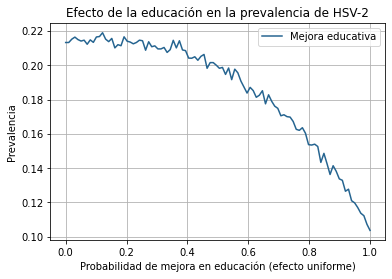

In [32]:
plt.title("Efecto de la educación en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejora en educación (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias, color='#256490', label='Mejora educativa')
plt.legend()
plt.grid()
plt.show()

In [12]:
prevalencias2 = []
for p in probabilidades:
    # Cambio uniforme
    o = 0
    df_int = df.copy()
    df_int['HIV acquisition'] = df_int['HIV acquisition'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['HIV-testing self-efficacy'] = df_int['HIV-testing self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Condom self-efficacy'] = df_int['Condom self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Control around sexual partners'] = df_int['Control around sexual partners'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Safe sex and condoms'] = df_int['Safe sex and condoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Sought treatment for STD symptoms'] = df_int['Sought treatment for STD symptoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Rights within marriage'] = df_int['Rights within marriage'].apply(lambda x: aplicar_cambio(x, o, p))

    o = 1
    df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalencias2.append(Prevalencia(df_int)[0])

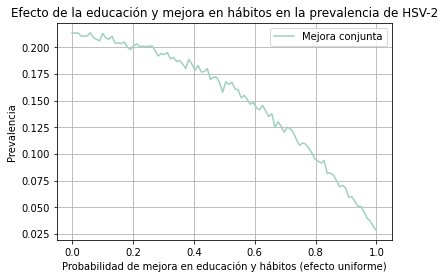

In [41]:
plt.title("Efecto de la educación y mejora en hábitos en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejora en educación y hábitos (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias2, color='#9dd1bd', label='Mejora conjunta')
plt.legend()
plt.grid()
plt.show()

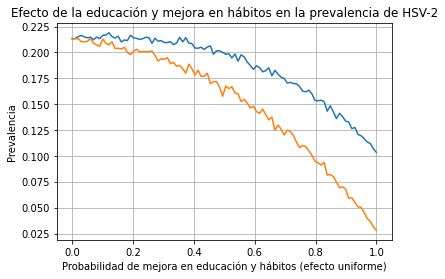

In [14]:
plt.title("Efecto de la educación y mejora en hábitos en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejora en educación y hábitos (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias)
plt.plot(probabilidades, prevalencias2)
plt.grid()
plt.show()

In [18]:
prevalenciasHabitos = []
for p in probabilidades:
    # Cambio uniforme
    df_int = df.copy()
    o = 1
    df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalenciasHabitos.append(Prevalencia(df_int)[0])

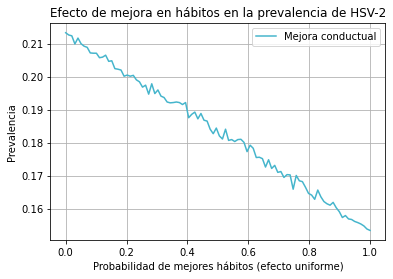

In [42]:
plt.title("Efecto de mejora en hábitos en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejores hábitos (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalenciasHabitos, color='#45b5cc', label='Mejora conductual')
plt.legend()
plt.grid()
plt.show()

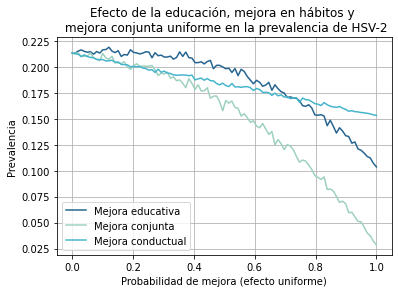

In [44]:
plt.title("Efecto de la educación, mejora en hábitos y \n mejora conjunta uniforme en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejora (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias, color='#256490', label="Mejora educativa")
plt.plot(probabilidades, prevalencias2, label="Mejora conjunta", color='#9dd1bd')
plt.plot(probabilidades, prevalenciasHabitos, color='#45b5cc', label="Mejora conductual")
plt.legend()
plt.grid()
plt.show()

In [20]:
prevalencias3 = []
for p in probabilidades:
    # Cambio uniforme
    o = 1
    df_int = df.copy()
    df_int['HIV acquisition'] = df_int['HIV acquisition'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['HIV-testing self-efficacy'] = df_int['HIV-testing self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Condom self-efficacy'] = df_int['Condom self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Control around sexual partners'] = df_int['Control around sexual partners'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Safe sex and condoms'] = df_int['Safe sex and condoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Sought treatment for STD symptoms'] = df_int['Sought treatment for STD symptoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Rights within marriage'] = df_int['Rights within marriage'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalencias3.append(Prevalencia(df_int)[0])

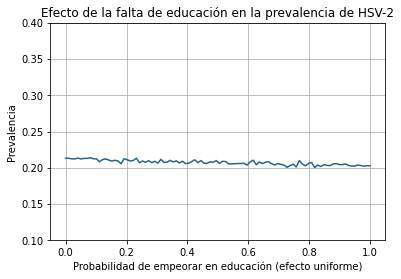

In [45]:
plt.title("Efecto de la falta de educación en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de empeorar en educación (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias3, color='#256490', label='Peores conocimientos')
plt.ylim(0.1,0.4)
plt.grid()
plt.show()

In [22]:
prevalencias4 = []
for p in probabilidades:
    # Cambio uniforme
    o = 0
    df_int = df.copy()
    df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalencias4.append(Prevalencia(df_int)[0])

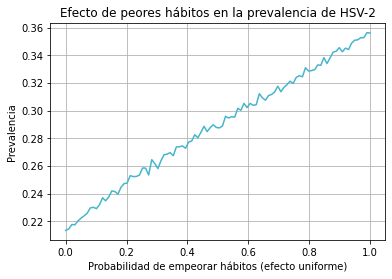

In [47]:
plt.title("Efecto de peores hábitos en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de empeorar hábitos (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades, prevalencias4, label='Peores hábitos', color='#45b5cc')
plt.grid()
plt.show()

In [48]:
prevalenciasPHC = []
for p in probabilidades:
    # Cambio uniforme
    o = 1
    df_int = df.copy()
    df_int['HIV acquisition'] = df_int['HIV acquisition'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['HIV-testing self-efficacy'] = df_int['HIV-testing self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Condom self-efficacy'] = df_int['Condom self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Control around sexual partners'] = df_int['Control around sexual partners'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Safe sex and condoms'] = df_int['Safe sex and condoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Sought treatment for STD symptoms'] = df_int['Sought treatment for STD symptoms'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Rights within marriage'] = df_int['Rights within marriage'].apply(lambda x: aplicar_cambio(x, o, p))

    o = 0
    df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, p))
    df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, p))

    prevalenciasPHC.append(Prevalencia(df_int)[0])

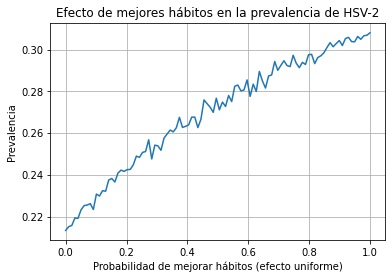

In [49]:
plt.title("Efecto de mejores hábitos en la prevalencia de HSV-2")
plt.xlabel("Probabilidad de mejorar hábitos (efecto uniforme)")
plt.ylabel("Prevalencia")
plt.plot(probabilidades,  prevalenciasPHC)
plt.grid()
plt.show()

In [68]:
prevalenciasSD = []
for p in probabilidades:
    # Cambio uniforme
    df_int = df.copy()
    o = 0
    df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, p))
    prevalenciasSD.append(Prevalencia(df_int)[0])

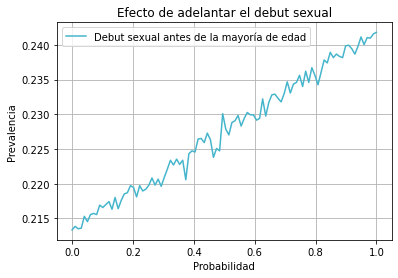

In [69]:
plt.title("Efecto de adelantar el debut sexual")
plt.xlabel("Probabilidad")
plt.ylabel("Prevalencia")
plt.plot(probabilidades,  prevalenciasSD, label='Debut sexual antes de la mayoría de edad', color='#45b5cc')
plt.legend()
plt.grid()
plt.show()

In [71]:
prevalenciasNP = []
for p in probabilidades:
    # Cambio uniforme
    df_int = df.copy()
    o = 1
    df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, p))
    prevalenciasNP.append(Prevalencia(df_int)[0])

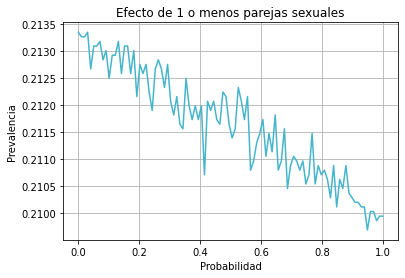

In [72]:
plt.title("Efecto de 1 o menos parejas sexuales")
plt.xlabel("Probabilidad")
plt.ylabel("Prevalencia")
plt.plot(probabilidades,  prevalenciasNP, label='1 o menos parejas sexuales en 12 meses', color='#45b5cc')
plt.grid()
plt.show()

In [74]:
prevalenciasUC = []
for p in probabilidades:
    # Cambio uniforme
    df_int = df.copy()
    o = 1
    df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, p))
    prevalenciasUC.append(Prevalencia(df_int)[0])

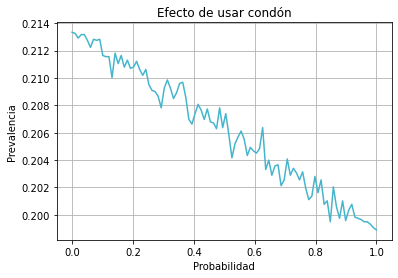

In [75]:
plt.title("Efecto de usar condón")
plt.xlabel("Probabilidad")
plt.ylabel("Prevalencia")
plt.plot(probabilidades,  prevalenciasUC, label='Usar condón', color='#45b5cc')
plt.grid()
plt.show()

In [85]:
prevalenciasABS = []
for p in probabilidades:
    # Cambio uniforme
    o = 1
    promedio = 0
    for i in range(30):
        df_int = df.copy()
        u = np.random.uniform(0, 1, 1)
        if u <= p:
            df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, 1))
            df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, 1))
            df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, 1))
            df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, 1))
            df_int['Ever had sex'] = df_int['Ever had sex'].apply(lambda x: aplicar_cambio(x, o, 1))
            df_int['Two or more lifetime partners'] = df_int['Two or more lifetime partners'].apply(lambda x: aplicar_cambio(x, o, 1))
        promedio = promedio + (Prevalencia(df_int)[0])
    prevalenciasABS.append(promedio/30)


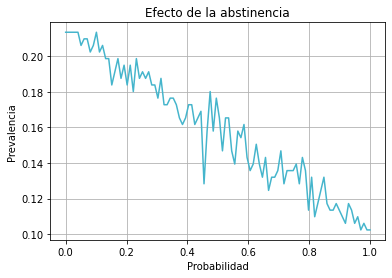

In [87]:
plt.title("Efecto de la abstinencia")
plt.xlabel("Probabilidad")
plt.ylabel("Prevalencia")
plt.plot(probabilidades,  prevalenciasABS, label='Abstinencia', color='#45b5cc')
plt.grid()
plt.show()

In [88]:
probabilidades = np.linspace(0, 1, 10)
prevalenciasefectocruzado = np.zeros((len(probabilidades), len(probabilidades)))
for i, p in enumerate(probabilidades):
    for j, q in enumerate(probabilidades):
        # Cambio uniforme
        o = 0
        df_int = df.copy()
        df_int['HIV acquisition'] = df_int['HIV acquisition'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['HIV-testing self-efficacy'] = df_int['HIV-testing self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['Condom self-efficacy'] = df_int['Condom self-efficacy'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['Control around sexual partners'] = df_int['Control around sexual partners'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['Safe sex and condoms'] = df_int['Safe sex and condoms'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['Sought treatment for STD symptoms'] = df_int['Sought treatment for STD symptoms'].apply(lambda x: aplicar_cambio(x, o, p))
        df_int['Rights within marriage'] = df_int['Rights within marriage'].apply(lambda x: aplicar_cambio(x, o, p))

        o = 1
        df_int['Sexual debut 17 or younger'] = df_int['Sexual debut 17 or younger'].apply(lambda x: aplicar_cambio(x, o, q))
        df_int['Two or more partners in last 12m'] = df_int['Two or more partners in last 12m'].apply(lambda x: aplicar_cambio(x, o, q))
        df_int['Did not use condom at last sex'] = df_int['Did not use condom at last sex'].apply(lambda x: aplicar_cambio(x, o, q))
        df_int['Reported past or current pregnancy'] = df_int['Reported past or current pregnancy'].apply(lambda x: aplicar_cambio(x, o, q))

        prevalenciasefectocruzado[i, j] = Prevalencia(df_int)[0]

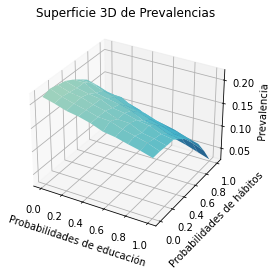

In [91]:
# Crear una malla para la gráfica
X, Y = np.meshgrid(probabilidades, probabilidades)
Z = prevalenciasefectocruzado

# Definir un colormap personalizado
colors = ['#256490', '#45b5cc', '#9dd1bd']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Crear la gráfica 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=custom_cmap)

ax.set_xlabel('Probabilidades de educación')
ax.set_ylabel('Probabilidades de hábitos')
ax.set_zlabel('Prevalencia')
ax.set_title('Superficie 3D de Prevalencias')

plt.show()

In [96]:
# Crear la gráfica 3D interactiva con plotly
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

colors = ['#256490', '#45b5cc', '#9dd1bd']
colorscale = make_colorscale(colors)

# Crear la gráfica 3D interactiva con Plotly
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale=colorscale)])

fig.update_layout(
    title='Superficie 3D de Prevalencias',
    scene=dict(
        xaxis_title='Probabilidades de educación',
        yaxis_title='Probabilidades de hábitos',
        zaxis_title='Prevalencia'
    ),
    width=1600,  # Ancho de la gráfica
    height=900   # Alto de la gráfica
)

# Mostrar la gráfica en pantalla completa
fig.show(renderer="browser")